In [1]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto(device_count = {'GPU': 0})#
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

Using TensorFlow backend.


In [12]:
# !retinanet-convert-model ./snapshots/resnet50_csv_30.h5 ./inference_model.h5

Using TensorFlow backend.
2019-05-05 23:17:51.679468: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2019-05-05 23:17:51.679514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] retrieving CUDA diagnostic information for host: HS
2019-05-05 23:17:51.679526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:170] hostname: HS
2019-05-05 23:17:51.679566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:194] libcuda reported version is: 390.116.0
2019-05-05 23:17:51.679596: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:198] kernel reported version is: 390.116.0
2019-05-05 23:17:51.679606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:305] kernel version seems to match DSO: 390.116.0


In [2]:
from keras_retinanet.models import load_model
model = load_model('./inference_model.h5', backbone_name='resnet50')

/home/protus/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
labels_to_names = {0: 'Healthy', 1:'Ill'}
names_to_labels = {'Healthy': 0, 'Ill':1}

def predict_model(image, model):
    """Прогноз модели"""
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    filtered = (scores>0.5)
      
    return boxes[filtered,:].astype(int), scores[filtered], labels[filtered]

def draw_image_with_labels(boxes, scores, labels, image):
    """Отображение картинки и полигонов"""
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    for box, score, label in zip(boxes, scores, labels):
        color = label_color(label)
        draw_box(draw, box, color=color, thickness=1)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, box, caption)
        
    return draw

def get_random_image(dataset):
    """Выбор случайной картинки из датасета"""
    import random as rnd
    #random image load
    files = dataset[0].unique()
    random_image_filename = files[rnd.randint(0,len(files))]
    return random_image_filename

def get_true_image(dataset, image_file_name):
    """Получение картинки с метаданными из датасета"""
    selected_files = dataset.loc[dataset[0]==image_file_name]
    boxes = selected_files[[1,2,3,4]].values
    scores = [1]*len(boxes)
    labels = dataset[5].map(names_to_labels)
    return boxes, scores, list(labels)

def plot_dataset_prediction(dataset, model, plot_rows=1):
    fig, ax = plt.subplots(plot_rows, 2, figsize=(15, 15*plot_rows*0.5))
    axes = ax.flatten()
    for i in range(plot_rows):
        random_image_filename = get_random_image(dataset)
        image = read_image_bgr(random_image_filename)
        draw_true = draw_image_with_labels(*get_true_image(dataset, random_image_filename), image)
        draw_pred = draw_image_with_labels(*predict_model(image, model), image)       
        
        axes[i*2].imshow(draw_true, origin='upper')
        axes[i*2+1].imshow(draw_pred, origin='upper')
    plt.show()

In [4]:
dataset = pd.read_csv('./DataSets/train_annotations.csv', header=None)

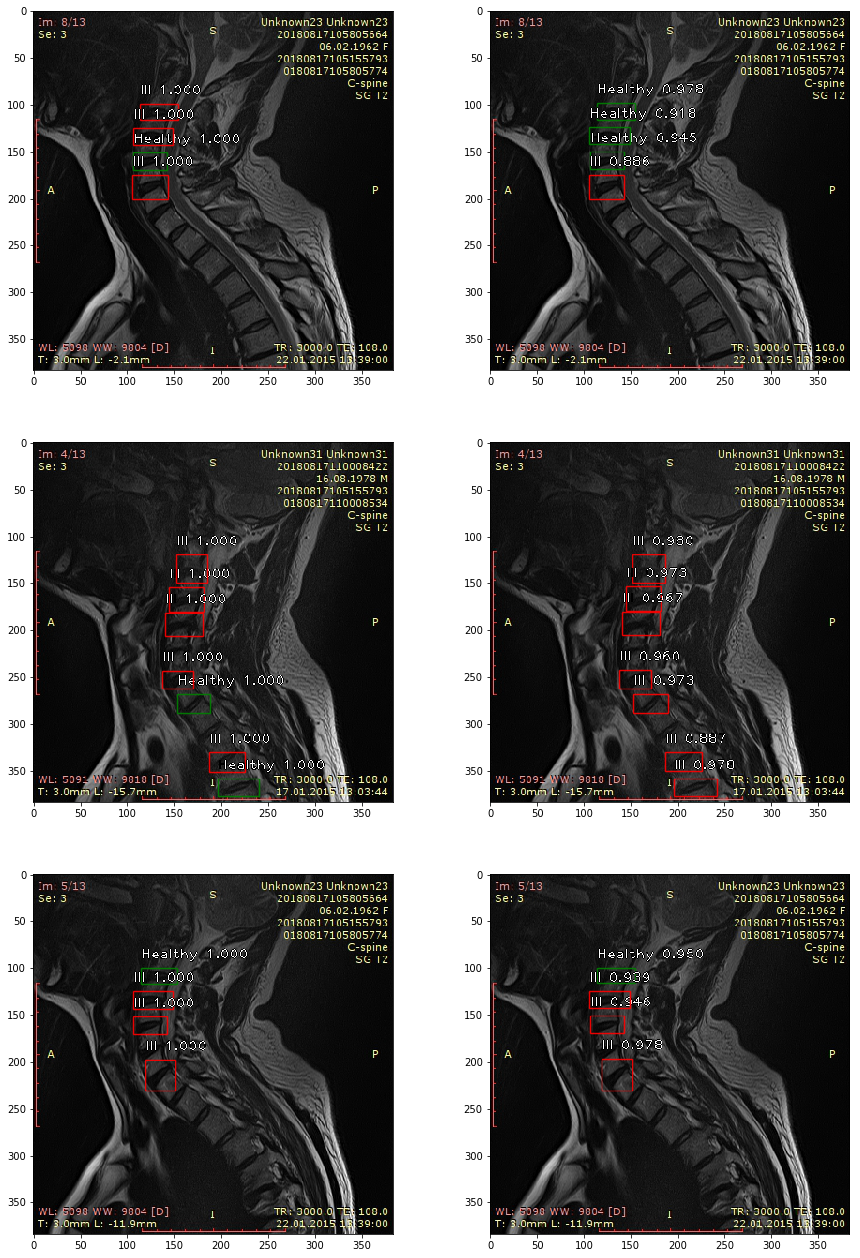

In [5]:
plot_dataset_prediction(dataset, model, plot_rows=3)